# 건강검진정보 데이터를 통한 성별 및 연령대 분류

1. import & Data Check
2. EDA
3. Feature Engineering 
4. Modeling

- train : 가입자일련번호 끝자리가 5가 아닌 데이터
- test : 가입자일년번호 끝자리가 5인 데이터(성별코드, 연령대코드 없앨 것)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
os.name
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus='False')

## 1. import & Data Check

In [3]:
os.listdir('dataset/medical-checkup_2017')

['medical-checkup-2017.csv']

In [4]:
data = pd.read_csv('dataset/medical-checkup_2017/medical-checkup-2017.csv')

In [5]:
data 
# 100만 개의 데이터, 34개의 변수로 구성

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),...,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
0,2017,1,1,8,43,170,75,90.0,1.0,1.0,...,40.0,1.0,Y,Y,NaN,NaN,NaN,NaN,Y,2018-11-26
1,2017,2,1,7,11,180,80,89.0,0.9,1.2,...,27.0,3.0,N,Y,NaN,NaN,NaN,NaN,NaN,2018-11-26
2,2017,3,1,9,41,165,75,91.0,1.2,1.5,...,68.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
3,2017,4,1,11,48,175,80,91.0,1.5,1.2,...,18.0,1.0,N,Y,NaN,NaN,NaN,NaN,N,2018-11-26
4,2017,5,1,11,30,165,60,80.0,1.0,1.2,...,25.0,1.0,N,Y,NaN,NaN,NaN,NaN,N,2018-11-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2017,999996,1,10,48,175,80,92.1,1.5,1.5,...,27.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
999996,2017,999997,1,8,41,170,75,86.0,1.0,1.5,...,15.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
999997,2017,999998,2,9,26,155,50,68.0,1.0,0.7,...,17.0,3.0,Y,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
999998,2017,999999,1,6,29,175,60,72.0,1.5,1.0,...,17.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26


In [6]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   기준년도          1000000 non-null  int64  
 1   가입자일련번호       1000000 non-null  int64  
 2   성별코드          1000000 non-null  int64  
 3   연령대코드(5세단위)   1000000 non-null  int64  
 4   시도코드          1000000 non-null  int64  
 5   신장(5Cm단위)     1000000 non-null  int64  
 6   체중(5Kg단위)     1000000 non-null  int64  
 7   허리둘레          999734 non-null   float64
 8   시력(좌)         999817 non-null   float64
 9   시력(우)         999811 non-null   float64
 10  청력(좌)         999842 non-null   float64
 11  청력(우)         999844 non-null   float64
 12  수축기혈압         999981 non-null   float64
 13  이완기혈압         999982 non-null   float64
 14  식전혈당(공복혈당)    999958 non-null   float64
 15  총콜레스테롤        999957 non-null   float64
 16  트리글리세라이드      999955 non-null   float64
 17  HDL콜레스테롤      999956 non-nul

### 1) 데이터 확인 및 분리

train과 test 데이터 분리하기 
1) 가입자 일련번호로 분리 수행
- 데이터 타입 수정
- 5로 안끝나면 train
- 5로 끝나면 test

train 데이터에 대해서만 수행
1) 연령대 데이터 10,20,30,40.. 으로 변경 처리
- 연도에 따라 다르게 수행할 것!


In [7]:
# 가입자일련번호 데이터 타입 변환

df = data
df = df.astype({'가입자일련번호':'str'})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   기준년도          1000000 non-null  int64  
 1   가입자일련번호       1000000 non-null  object 
 2   성별코드          1000000 non-null  int64  
 3   연령대코드(5세단위)   1000000 non-null  int64  
 4   시도코드          1000000 non-null  int64  
 5   신장(5Cm단위)     1000000 non-null  int64  
 6   체중(5Kg단위)     1000000 non-null  int64  
 7   허리둘레          999734 non-null   float64
 8   시력(좌)         999817 non-null   float64
 9   시력(우)         999811 non-null   float64
 10  청력(좌)         999842 non-null   float64
 11  청력(우)         999844 non-null   float64
 12  수축기혈압         999981 non-null   float64
 13  이완기혈압         999982 non-null   float64
 14  식전혈당(공복혈당)    999958 non-null   float64
 15  총콜레스테롤        999957 non-null   float64
 16  트리글리세라이드      999955 non-null   float64
 17  HDL콜레스테롤      999956 non-nul

In [9]:
df_train = df[-df['가입자일련번호'].str.endswith('5')]
df_test = df[df['가입자일련번호'].str.endswith('5')]

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   기준년도          900000 non-null  int64  
 1   가입자일련번호       900000 non-null  object 
 2   성별코드          900000 non-null  int64  
 3   연령대코드(5세단위)   900000 non-null  int64  
 4   시도코드          900000 non-null  int64  
 5   신장(5Cm단위)     900000 non-null  int64  
 6   체중(5Kg단위)     900000 non-null  int64  
 7   허리둘레          899762 non-null  float64
 8   시력(좌)         899839 non-null  float64
 9   시력(우)         899833 non-null  float64
 10  청력(좌)         899859 non-null  float64
 11  청력(우)         899861 non-null  float64
 12  수축기혈압         899982 non-null  float64
 13  이완기혈압         899983 non-null  float64
 14  식전혈당(공복혈당)    899962 non-null  float64
 15  총콜레스테롤        899962 non-null  float64
 16  트리글리세라이드      899960 non-null  float64
 17  HDL콜레스테롤      899961 non-null  float64
 18  LDL콜

In [11]:
df_train

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),...,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
0,2017,1,1,8,43,170,75,90.0,1.0,1.0,...,40.0,1.0,Y,Y,NaN,NaN,NaN,NaN,Y,2018-11-26
1,2017,2,1,7,11,180,80,89.0,0.9,1.2,...,27.0,3.0,N,Y,NaN,NaN,NaN,NaN,NaN,2018-11-26
2,2017,3,1,9,41,165,75,91.0,1.2,1.5,...,68.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
3,2017,4,1,11,48,175,80,91.0,1.5,1.2,...,18.0,1.0,N,Y,NaN,NaN,NaN,NaN,N,2018-11-26
5,2017,6,1,11,41,165,55,75.0,1.2,1.5,...,37.0,3.0,Y,Y,NaN,NaN,NaN,NaN,NaN,2018-11-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2017,999996,1,10,48,175,80,92.1,1.5,1.5,...,27.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
999996,2017,999997,1,8,41,170,75,86.0,1.0,1.5,...,15.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
999997,2017,999998,2,9,26,155,50,68.0,1.0,0.7,...,17.0,3.0,Y,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
999998,2017,999999,1,6,29,175,60,72.0,1.5,1.0,...,17.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26


In [12]:
df_train['기준년도'].value_counts()

2017    900000
Name: 기준년도, dtype: int64

In [13]:
df_test

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),...,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
4,2017,5,1,11,30,165,60,80.0,1.0,1.2,...,25.0,1.0,N,Y,NaN,NaN,NaN,NaN,N,2018-11-26
14,2017,15,2,7,41,160,50,76.0,0.9,1.0,...,58.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
24,2017,25,2,5,44,160,55,79.0,1.2,1.5,...,15.0,1.0,Y,Y,NaN,NaN,NaN,NaN,Y,2018-11-26
34,2017,35,1,7,48,170,80,94.0,0.9,1.5,...,29.0,3.0,Y,Y,NaN,NaN,NaN,NaN,Y,2018-11-26
44,2017,45,2,7,27,160,60,74.0,0.8,0.7,...,15.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999954,2017,999955,2,8,48,160,60,76.0,1.0,1.0,...,17.0,1.0,Y,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
999964,2017,999965,1,8,11,170,70,82.0,1.0,1.2,...,50.0,3.0,Y,Y,NaN,NaN,NaN,NaN,N,2018-11-26
999974,2017,999975,2,13,11,155,50,69.5,0.9,0.9,...,25.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
999984,2017,999985,2,11,50,150,60,85.0,1.0,0.8,...,30.0,1.0,N,Y,NaN,NaN,NaN,NaN,Y,2018-11-26


test 데이터 target 변수 삭제

In [14]:
df_test.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

In [15]:
df_test.drop(['성별코드', '연령대코드(5세단위)'], axis = 1, inplace = True) 

In [16]:
df_test.columns

Index(['기준년도', '가입자일련번호', '시도코드', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레', '시력(좌)',
       '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤',
       '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부', '구강검진수검여부',
       '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석', '데이터공개일자'],
      dtype='object')

In [17]:
df_train['연령대코드(5세단위)'].value_counts() # 5부터 18까지

9     118391
11    117460
10    107205
12    100703
13     96136
8      76761
7      70494
6      58395
14     48144
15     46163
16     23207
5      19961
17     13855
18      3125
Name: 연령대코드(5세단위), dtype: int64

https://velog.io/@dlskawns/Dataframe-%EB%82%B4-%ED%8A%B9%EC%A0%95Column-row%EC%9D%98-%EC%84%A0%ED%83%9D-%EC%A1%B0%EA%B1%B4%EB%B6%80-%EC%84%A0%ED%83%9D-%EB%B3%80%EA%B2%BD%ED%95%98%EA%B8%B0

연령대코드 이름 변경하고, 나이대로 나눠서 저장하기

In [18]:
df_train.rename(columns = {'연령대코드(5세단위)':'연령대코드'}, inplace=True)

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   기준년도          900000 non-null  int64  
 1   가입자일련번호       900000 non-null  object 
 2   성별코드          900000 non-null  int64  
 3   연령대코드         900000 non-null  int64  
 4   시도코드          900000 non-null  int64  
 5   신장(5Cm단위)     900000 non-null  int64  
 6   체중(5Kg단위)     900000 non-null  int64  
 7   허리둘레          899762 non-null  float64
 8   시력(좌)         899839 non-null  float64
 9   시력(우)         899833 non-null  float64
 10  청력(좌)         899859 non-null  float64
 11  청력(우)         899861 non-null  float64
 12  수축기혈압         899982 non-null  float64
 13  이완기혈압         899983 non-null  float64
 14  식전혈당(공복혈당)    899962 non-null  float64
 15  총콜레스테롤        899962 non-null  float64
 16  트리글리세라이드      899960 non-null  float64
 17  HDL콜레스테롤      899961 non-null  float64
 18  LDL콜

In [20]:
k = 20
for i in range(5, 19, 2):
    if k == 80:
        df_train.loc[(df_train['연령대코드']== i) |(df_train['연령대코드'] == i+1), '연령대코드'] = str(k)+'대이상'
    else:
        df_train.loc[(df_train['연령대코드']== i) |(df_train['연령대코드'] == i+1), '연령대코드'] = str(k)+'대'
    k += 10
    
df_train['연령대코드'].value_counts()

40대      225596
50대      218163
30대      147255
60대      144280
20대       78356
70대       69370
80대이상     16980
Name: 연령대코드, dtype: int64

In [ ]:
# df_train[df_train['연령대코드']== '80'] = '80대이상'
# 이거 하면 dtype이 모두 object로 변경됨ㅜ

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   기준년도          900000 non-null  int64  
 1   가입자일련번호       900000 non-null  object 
 2   성별코드          900000 non-null  int64  
 3   연령대코드         900000 non-null  object 
 4   시도코드          900000 non-null  int64  
 5   신장(5Cm단위)     900000 non-null  int64  
 6   체중(5Kg단위)     900000 non-null  int64  
 7   허리둘레          899762 non-null  float64
 8   시력(좌)         899839 non-null  float64
 9   시력(우)         899833 non-null  float64
 10  청력(좌)         899859 non-null  float64
 11  청력(우)         899861 non-null  float64
 12  수축기혈압         899982 non-null  float64
 13  이완기혈압         899983 non-null  float64
 14  식전혈당(공복혈당)    899962 non-null  float64
 15  총콜레스테롤        899962 non-null  float64
 16  트리글리세라이드      899960 non-null  float64
 17  HDL콜레스테롤      899961 non-null  float64
 18  LDL콜

In [22]:
df_train.shape, df_test.shape

((900000, 34), (100000, 32))

변수 이름 변경

In [23]:
df_train.rename(columns={'기준년도' :'year', '가입자일련번호':'id', '성별코드':'target_sex','연령대코드':'target_age', '시도코드':'sido', 
                          '신장(5Cm단위)':'height', '체중(5Kg단위)':'weight', '허리둘레' : 'waist',
                          '시력(좌)':'sight_L', '시력(우)':'sight_R', '청력(좌)':'hear_L', '청력(우)':'hear_R',
                          '수축기혈압':'bp_high', '이완기혈압':'bp_low', '식전혈당(공복혈당)':'blds',
                          '총콜레스테롤':'tot_chole', '트리글리세라이드':'triglyceride', 'HDL콜레스테롤':'hdl_chole', 
                          'LDL콜레스테롤':'ldl_chole', '혈색소':'hmg', '요단백':'olig_prote_cd',
                          '혈청크레아티닌':'creatinine','(혈청지오티)AST':'sgot_ast', '(혈청지오티)ALT':'sgot_alt', '감마지티피':'gamma_gtp', 
                          '흡연상태':'smk_type', '음주여부':'drk_yn', '구강검진수검여부':'hchk_yn',
                          '치아우식증유무':'crs_yn', '결손치유무':'tth_yn', '치아마모증유무':'odt_yn',
                          '제3대구치(사랑니)이상':'wsdm_dis_yn', '치석':'ttr_yn', '데이터공개일자':'data_dt'}, inplace = True)

In [24]:
df_test.rename(columns={'기준년도' :'year', '가입자일련번호':'id', '시도코드':'sido', 
                          '신장(5Cm단위)':'height', '체중(5Kg단위)':'weight', '허리둘레' : 'waist',
                          '시력(좌)':'sight_L', '시력(우)':'sight_R', '청력(좌)':'hear_L', '청력(우)':'hear_R',
                          '수축기혈압':'bp_high', '이완기혈압':'bp_low', '식전혈당(공복혈당)':'blds',
                          '총콜레스테롤':'tot_chole', '트리글리세라이드':'triglyceride', 'HDL콜레스테롤':'hdl_chole', 
                          'LDL콜레스테롤':'ldl_chole', '혈색소':'hmg', '요단백':'olig_prote_cd',
                          '혈청크레아티닌':'creatinine','(혈청지오티)AST':'sgot_ast', '(혈청지오티)ALT':'sgot_alt', '감마지티피':'gamma_gtp', 
                          '흡연상태':'smk_type', '음주여부':'drk_yn', '구강검진수검여부':'hchk_yn',
                          '치아우식증유무':'crs_yn', '결손치유무':'tth_yn', '치아마모증유무':'odt_yn',
                          '제3대구치(사랑니)이상':'wsdm_dis_yn', '치석':'ttr_yn', '데이터공개일자':'data_dt'}, inplace = True)

In [25]:
print(df_train.columns)
print(df_test.columns)

Index(['year', 'id', 'target_sex', 'target_age', 'sido', 'height', 'weight',
       'waist', 'sight_L', 'sight_R', 'hear_L', 'hear_R', 'bp_high', 'bp_low',
       'blds', 'tot_chole', 'triglyceride', 'hdl_chole', 'ldl_chole', 'hmg',
       'olig_prote_cd', 'creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp',
       'smk_type', 'drk_yn', 'hchk_yn', 'crs_yn', 'tth_yn', 'odt_yn',
       'wsdm_dis_yn', 'ttr_yn', 'data_dt'],
      dtype='object')
Index(['year', 'id', 'sido', 'height', 'weight', 'waist', 'sight_L', 'sight_R',
       'hear_L', 'hear_R', 'bp_high', 'bp_low', 'blds', 'tot_chole',
       'triglyceride', 'hdl_chole', 'ldl_chole', 'hmg', 'olig_prote_cd',
       'creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp', 'smk_type', 'drk_yn',
       'hchk_yn', 'crs_yn', 'tth_yn', 'odt_yn', 'wsdm_dis_yn', 'ttr_yn',
       'data_dt'],
      dtype='object')


In [26]:
# data_dt는 의미가 없어서 drop하겠음
df_train.drop('data_dt', axis=1, inplace=True)
df_test.drop('data_dt', axis=1, inplace=True)

In [27]:
df_train.shape, df_test.shape

((900000, 33), (100000, 31))

### 2) 결측치 확인

In [28]:
for col in df_train.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msperc)

column:       year	 Percent of NaN value: 0.00%
column:         id	 Percent of NaN value: 0.00%
column: target_sex	 Percent of NaN value: 0.00%
column: target_age	 Percent of NaN value: 0.00%
column:       sido	 Percent of NaN value: 0.00%
column:     height	 Percent of NaN value: 0.00%
column:     weight	 Percent of NaN value: 0.00%
column:      waist	 Percent of NaN value: 0.03%
column:    sight_L	 Percent of NaN value: 0.02%
column:    sight_R	 Percent of NaN value: 0.02%
column:     hear_L	 Percent of NaN value: 0.02%
column:     hear_R	 Percent of NaN value: 0.02%
column:    bp_high	 Percent of NaN value: 0.00%
column:     bp_low	 Percent of NaN value: 0.00%
column:       blds	 Percent of NaN value: 0.00%
column:  tot_chole	 Percent of NaN value: 0.00%
column: triglyceride	 Percent of NaN value: 0.00%
column:  hdl_chole	 Percent of NaN value: 0.00%
column:  ldl_chole	 Percent of NaN value: 0.29%
column:        hmg	 Percent of NaN value: 0.01%
column: olig_prote_cd	 Percent of NaN 

In [29]:
for col in df_test.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msperc)

column:       year	 Percent of NaN value: 0.00%
column:         id	 Percent of NaN value: 0.00%
column:       sido	 Percent of NaN value: 0.00%
column:     height	 Percent of NaN value: 0.00%
column:     weight	 Percent of NaN value: 0.00%
column:      waist	 Percent of NaN value: 0.03%
column:    sight_L	 Percent of NaN value: 0.02%
column:    sight_R	 Percent of NaN value: 0.02%
column:     hear_L	 Percent of NaN value: 0.02%
column:     hear_R	 Percent of NaN value: 0.02%
column:    bp_high	 Percent of NaN value: 0.00%
column:     bp_low	 Percent of NaN value: 0.00%
column:       blds	 Percent of NaN value: 0.00%
column:  tot_chole	 Percent of NaN value: 0.01%
column: triglyceride	 Percent of NaN value: 0.01%
column:  hdl_chole	 Percent of NaN value: 0.01%
column:  ldl_chole	 Percent of NaN value: 0.28%
column:        hmg	 Percent of NaN value: 0.01%
column: olig_prote_cd	 Percent of NaN value: 0.42%
column: creatinine	 Percent of NaN value: 0.00%
column:   sgot_ast	 Percent of NaN 

In [30]:
# crs_yn tth_yn odt_yn wsdm_dis_yn : 100퍼.
# 지움

df_train.drop(['crs_yn', 'tth_yn','odt_yn','wsdm_dis_yn'],axis = 1, inplace=True)
df_test.drop(['crs_yn', 'tth_yn','odt_yn','wsdm_dis_yn'],axis = 1, inplace=True)

In [31]:
df_train.shape, df_test.shape

((900000, 29), (100000, 27))

### 3) 이상치 확인

In [32]:
# 기본적으로 이상치는 numerical 데이터에서 확인될 수 있기 때문에
numerical_features = df_train.dtypes[df_train.dtypes != object].index
print(len(numerical_features), numerical_features)
print('*'*100)
numerical_features = df_train.dtypes[df_train.dtypes == object].index
print(len(numerical_features), numerical_features)

# 29개 맞음

24 Index(['year', 'target_sex', 'sido', 'height', 'weight', 'waist', 'sight_L',
       'sight_R', 'hear_L', 'hear_R', 'bp_high', 'bp_low', 'blds', 'tot_chole',
       'triglyceride', 'hdl_chole', 'ldl_chole', 'hmg', 'olig_prote_cd',
       'creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp', 'smk_type'],
      dtype='object')
****************************************************************************************************
5 Index(['id', 'target_age', 'drk_yn', 'hchk_yn', 'ttr_yn'], dtype='object')


In [33]:
# 여기서 n이 뭘뜻하지? - 확인해둘 것..........
# 그리고 왜 test데이터에 대해서는 확인 안하지?


def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5*IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v> n)
    
    return multiple_outliers

Outlier_to_drop = detect_outliers(df_train, 2,['height', 'weight', 'waist', 'sight_L',
       'sight_R','bp_high', 'bp_low', 'blds', 'tot_chole',
       'triglyceride', 'hdl_chole', 'ldl_chole', 'hmg', 'olig_prote_cd',
       'creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp', 'smk_type'])

In [34]:
df_train.loc[Outlier_to_drop] # 0개

,year,id,target_sex,target_age,sido,height,weight,waist,sight_L,sight_R,...,hmg,olig_prote_cd,creatinine,sgot_ast,sgot_alt,gamma_gtp,smk_type,drk_yn,hchk_yn,ttr_yn


In [35]:
df_train.shape

(900000, 29)

In [38]:
# 여기까지 데이터 저장 
df_train.to_csv('dataset/medical-checkup_2017/train.csv',index=False,encoding='CP949')
df_test.to_csv('dataset/medical-checkup_2017/test.csv',index=False,encoding='CP949')

### 4) 비대칭성 확인

이번 target 변수는 범주형 자료임
이 데이터의 비대칭성도 확인해봐야하는 걸까?

일단은 수치형 변수들에 대한 비대칭성을 확인해보자


In [50]:
numerical_features = df_train[['height', 'weight', 'waist', 'sight_L',
       'sight_R','bp_high', 'bp_low', 'blds', 'tot_chole',
       'triglyceride', 'hdl_chole', 'ldl_chole', 'hmg', 'olig_prote_cd',
       'creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp', 'smk_type']].dtypes.index

In [51]:
for col in numerical_features:
    print('{:15}'.format(col),
          'Skewness : {:05.2f}'.format(df_train[col].skew()),
         '  ', 
         'Kurtosis : {:06.2f}'.format(df_train[col].kurt()),)

height          Skewness : -0.02    Kurtosis : -00.53
weight          Skewness : 00.58    Kurtosis : 000.36
waist           Skewness : 26.32    Kurtosis : 2041.14
sight_L         Skewness : 09.98    Kurtosis : 143.73
sight_R         Skewness : 10.02    Kurtosis : 144.72
bp_high         Skewness : 00.48    Kurtosis : 000.99
bp_low          Skewness : 00.40    Kurtosis : 000.89
blds            Skewness : 04.60    Kurtosis : 040.22
tot_chole       Skewness : 01.61    Kurtosis : 052.07
triglyceride    Skewness : 06.83    Kurtosis : 184.80
hdl_chole       Skewness : 153.72    Kurtosis : 59659.65
ldl_chole       Skewness : 05.45    Kurtosis : 516.24
hmg             Skewness : -0.39    Kurtosis : 000.71
olig_prote_cd   Skewness : 05.66    Kurtosis : 036.76
creatinine      Skewness : 100.65    Kurtosis : 16136.05
sgot_ast        Skewness : 151.52    Kurtosis : 49207.38
sgot_alt        Skewness : 52.05    Kurtosis : 9127.83
gamma_gtp       Skewness : 07.72    Kurtosis : 096.72
smk_type        S

## EDA

### 1) numerical feature
heat map, 상관관계 파악
데이터 형태 파악  

1) target_sex  

2) target_age

### 1-1) target_sex

In [70]:
corr_data_sex = df_train[['height', 'weight', 'waist', 'sight_L','sight_R',
            'bp_high', 'bp_low', 'blds', 'tot_chole', 'triglyceride', 'hdl_chole', 'ldl_chole', 
            'hmg', 'olig_prote_cd','creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp', 'smk_type',
            'target_sex']]
# 이거 넣을 때는 인덱스 말고

In [71]:
df_train['target_sex'].value_counts()

1    477302
2    422698
Name: target_sex, dtype: int64

<AxesSubplot:title={'center':'Correlation of Numeric Features with target_sex'}>

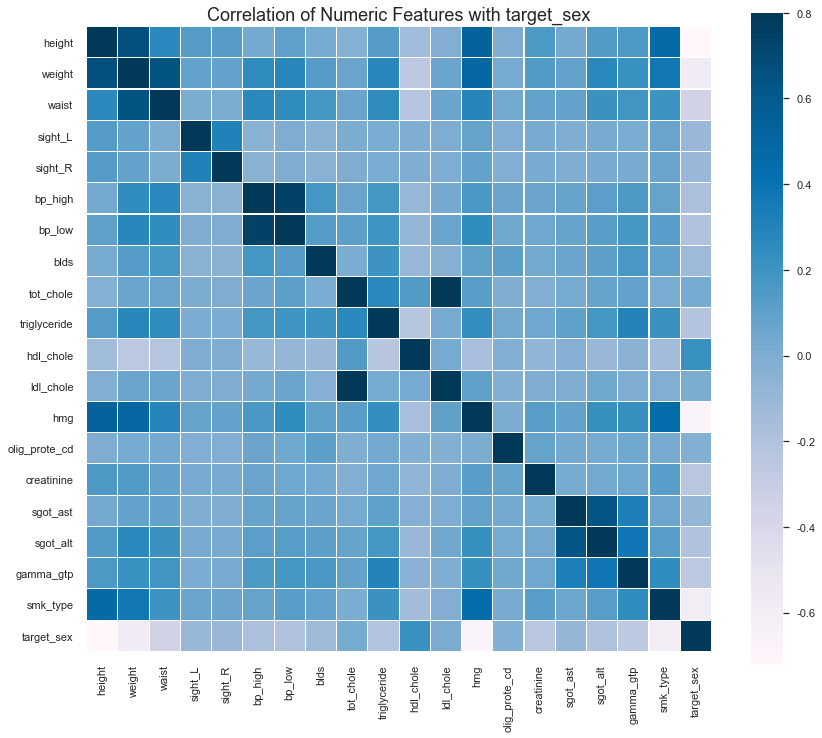

In [72]:
colormap = plt.cm.PuBu
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features with target_sex', y= 1, size=18)

sns.heatmap(corr_data_sex.corr(), square = True, linewidths = 0.1, 
            cmap = colormap, linecolor = 'white', vmax = 0.8)

In [73]:
# zoomed heat map

k = 10
cols = corr_data_sex.corr().nlargest(k, 'target_sex')['target_sex'].index
print(cols)

Index(['target_sex', 'hdl_chole', 'tot_chole', 'ldl_chole', 'olig_prote_cd',
       'sgot_ast', 'sight_L', 'sight_R', 'blds', 'bp_high'],
      dtype='object')


<AxesSubplot:>

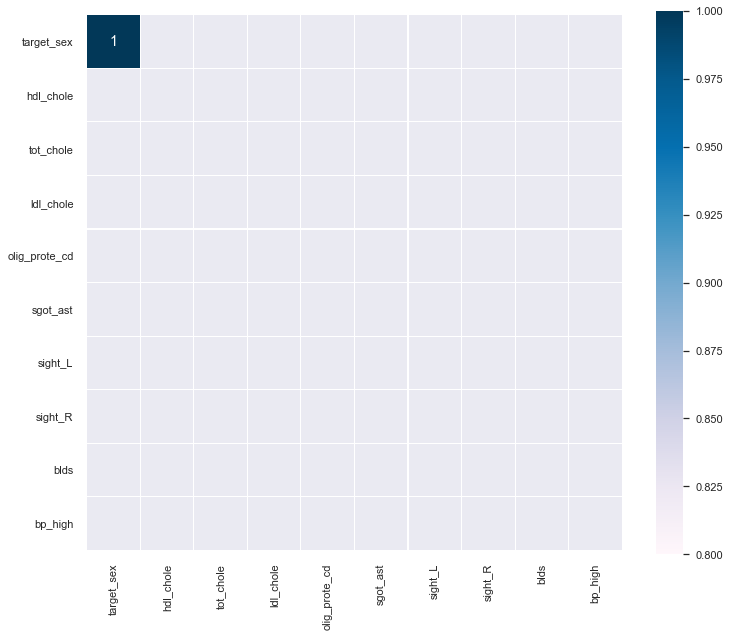

In [74]:
cm = np.corrcoef(df_train[cols].values.T)
f,ax = plt.subplots(figsize = (12,10))

sns.heatmap(cm, vmax=.8, linewidths = 0.1, square=True, annot = True, cmap=colormap,
           linecolor = 'white', xticklabels= cols.values, annot_kws = {'size':14},
           yticklabels = cols.values)

이게 머선일 ............................................

In [79]:
# 2. target_age에 대한 heat map

corr_data = df_train[['height', 'weight', 'waist', 'sight_L','sight_R',
            'bp_high', 'bp_low', 'blds', 'tot_chole', 'triglyceride', 'hdl_chole', 'ldl_chole', 
            'hmg', 'olig_prote_cd','creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp', 'smk_type','target_age']]

In [80]:
corr_data

,height,weight,waist,sight_L,sight_R,bp_high,bp_low,blds,tot_chole,triglyceride,hdl_chole,ldl_chole,hmg,olig_prote_cd,creatinine,sgot_ast,sgot_alt,gamma_gtp,smk_type,target_age
0,170,75,90.0,1.0,1.0,120.0,80.0,99.0,193.0,92.0,48.0,126.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,30대
1,180,80,89.0,0.9,1.2,130.0,82.0,106.0,228.0,121.0,55.0,148.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,30대
2,165,75,91.0,1.2,1.5,120.0,70.0,98.0,136.0,104.0,41.0,74.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,40대
3,175,80,91.0,1.5,1.2,145.0,87.0,95.0,201.0,106.0,76.0,104.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,50대
5,165,55,75.0,1.2,1.5,142.0,92.0,99.0,218.0,232.0,77.0,95.0,13.8,3.0,0.8,29.0,40.0,37.0,3.0,50대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,175,80,92.1,1.5,1.5,114.0,80.0,88.0,198.0,132.0,46.0,125.0,15.0,1.0,1.0,26.0,36.0,27.0,1.0,40대
999996,170,75,86.0,1.0,1.5,119.0,83.0,83.0,133.0,45.0,40.0,84.0,15.8,1.0,1.1,14.0,17.0,15.0,1.0,30대
999997,155,50,68.0,1.0,0.7,110.0,70.0,90.0,205.0,157.0,96.0,77.0,14.3,1.0,0.8,30.0,27.0,17.0,3.0,40대
999998,175,60,72.0,1.5,1.0,119.0,74.0,69.0,122.0,53.0,38.0,73.0,14.5,1.0,0.8,21.0,14.0,17.0,1.0,20대


In [76]:
df_train['target_age'].value_counts()

40대      225596
50대      218163
30대      147255
60대      144280
20대       78356
70대       69370
80대이상     16980
Name: target_age, dtype: int64

<AxesSubplot:title={'center':'Correlation of Numeric Features with target_age'}>

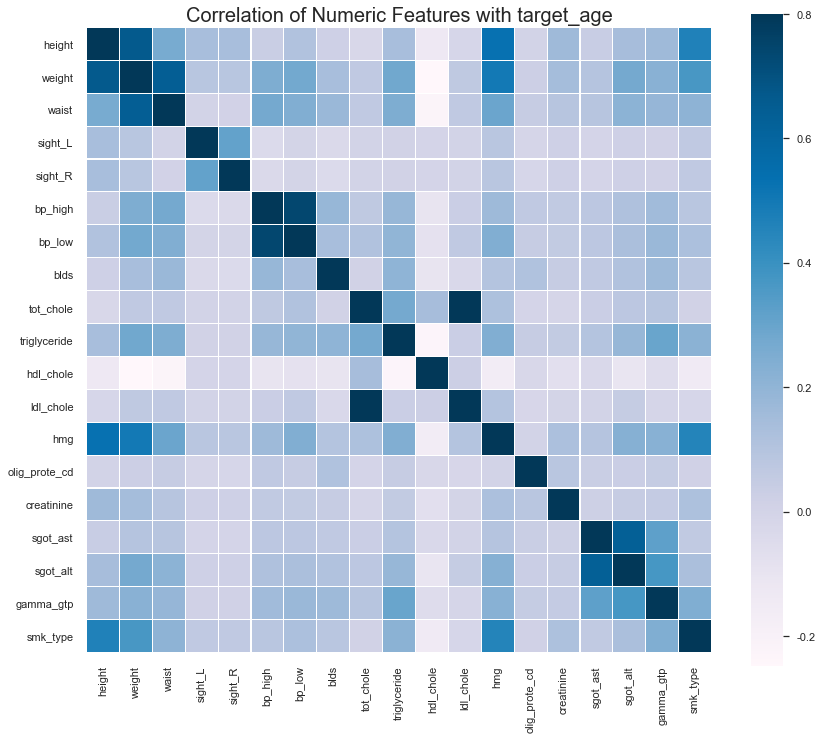

In [77]:
colormap = plt.cm.PuBu
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features with target_age', y= 1, size=20)

sns.heatmap(corr_data.corr(), square = True, linewidths = 0.1, 
            cmap = colormap, linecolor = 'white', vmax = 0.8)

In [78]:
k = 10
cols = corr_data.corr().nlargest(k, 'target_age')['target_age'].index
print(cols)

KeyError: 'target_age'

### 2) categorical feature
박스플랏, count 그려보고 치우친 데이터나 결측치 어떻게 처리할 지 파악
데이터에 대한 정보 전달

target에 가장 큰 영향을 미치는 변수를 찾고, 
그 변수 - target - 범주형 돌려서 확인해보는건 어떠신지...?
numerical 변수들에 대한 정보를 일단 찾고
그리고 범주 2개 밖에 없는 yn 들은 한번에 합치거나 해서 (소비예측 때처럼)

In [149]:
df_train.shape, df_test.shape

((900000, 29), (100000, 27))

In [154]:
print(df_train.columns)
numerical_features = df_train.dtypes[df_train.dtypes != object].index
print(numerical_features)
print(categorical_features)

Index(['year', 'id', 'target_sex', 'target_age', 'sido', 'height', 'weight',
       'waist', 'sight_L', 'sight_R', 'hear_L', 'hear_R', 'bp_high', 'bp_low',
       'blds', 'tot_chole', 'triglyceride', 'hdl_chole', 'ldl_chole', 'hmg',
       'olig_prote_cd', 'creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp',
       'smk_type', 'drk_yn', 'hchk_yn', 'ttr_yn'],
      dtype='object')
Index(['year', 'target_sex', 'sido', 'height', 'weight', 'waist', 'sight_L',
       'sight_R', 'hear_L', 'hear_R', 'bp_high', 'bp_low', 'blds', 'tot_chole',
       'triglyceride', 'hdl_chole', 'ldl_chole', 'hmg', 'olig_prote_cd',
       'creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp', 'smk_type'],
      dtype='object')
Index(['id', 'target_age', 'drk_yn', 'hchk_yn', 'ttr_yn'], dtype='object')


In [ ]:
df_train1 = df_train[:10000]

확실하게 numerical과 categorical을 나누겠습니다요 - target_sex, target_age

총 29개의 변수
target변수를 제외하면 총 27개의 변수 
id 변수도 나중에 고려해둘것
year 변수는 2017밖에 없어서 제외


'id', 'height', 'weight', 'waist', 'sight_L','sight_R','bp_high', 'bp_low', 'blds', 
'tot_chole','triglyceride', 'hdl_chole', 'ldl_chole', 'hmg', 'creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp'

'sido','hear_L', 'hear_R', 'olig_prote_cd','smk_type', 'drk_yn', 'hchk_yn', 'ttr_yn'

In [164]:
numerical_features = df_train[['id','height', 'weight', 'waist', 'sight_L','sight_R','bp_high', 'bp_low', 'blds', 
'tot_chole','triglyceride', 'hdl_chole', 'ldl_chole', 'hmg', 'creatinine', 'sgot_ast', 'sgot_alt', 'gamma_gtp']].dtypes.index

categorical_features = df_train[['sido','hear_L', 'hear_R', 'olig_prote_cd','smk_type', 'drk_yn', 'hchk_yn', 'ttr_yn']].dtypes.index

In [165]:
# target_sex, target_age

print("numerical_features : ", len(numerical_features)) # 18개 (id 변수 포함)
print("*"*50)
print("categorical_features : ", len(categorical_features)) # year 변수 제거

numerical_features :  18
**************************************************
categorical_features :  8


In [179]:
# 이번에는 변수 먼저 볼것이여

for catg in list(categorical_features):
    print(df_train[catg].value_counts())
    print('*'*50)

# 우려했던 것 처럼 0이 Y가 된다거나 하는 경우가 없음을 확인

41    222017
11    160762
26     62236
48     60826
28     52364
47     48914
27     42995
44     37928
46     33895
45     32982
43     30483
42     27147
30     26630
29     25210
31     22583
50      9234
36      3794
Name: sido, dtype: int64
**************************************************
1.0    871262
2.0     28597
Name: hear_L, dtype: int64
**************************************************
1.0    872280
2.0     27581
Name: hear_R, dtype: int64
**************************************************
1.0    844945
2.0     27943
3.0     14831
4.0      5855
5.0      1791
6.0       461
Name: olig_prote_cd, dtype: int64
**************************************************
1.0    547269
3.0    194054
2.0    158545
Name: smk_type, dtype: int64
**************************************************
N    450813
Y    448697
Name: drk_yn, dtype: int64
**************************************************
N    539561
Y    360439
Name: hchk_yn, dtype: int64
**********************************************

<AxesSubplot:xlabel='ttr_yn', ylabel='count'>

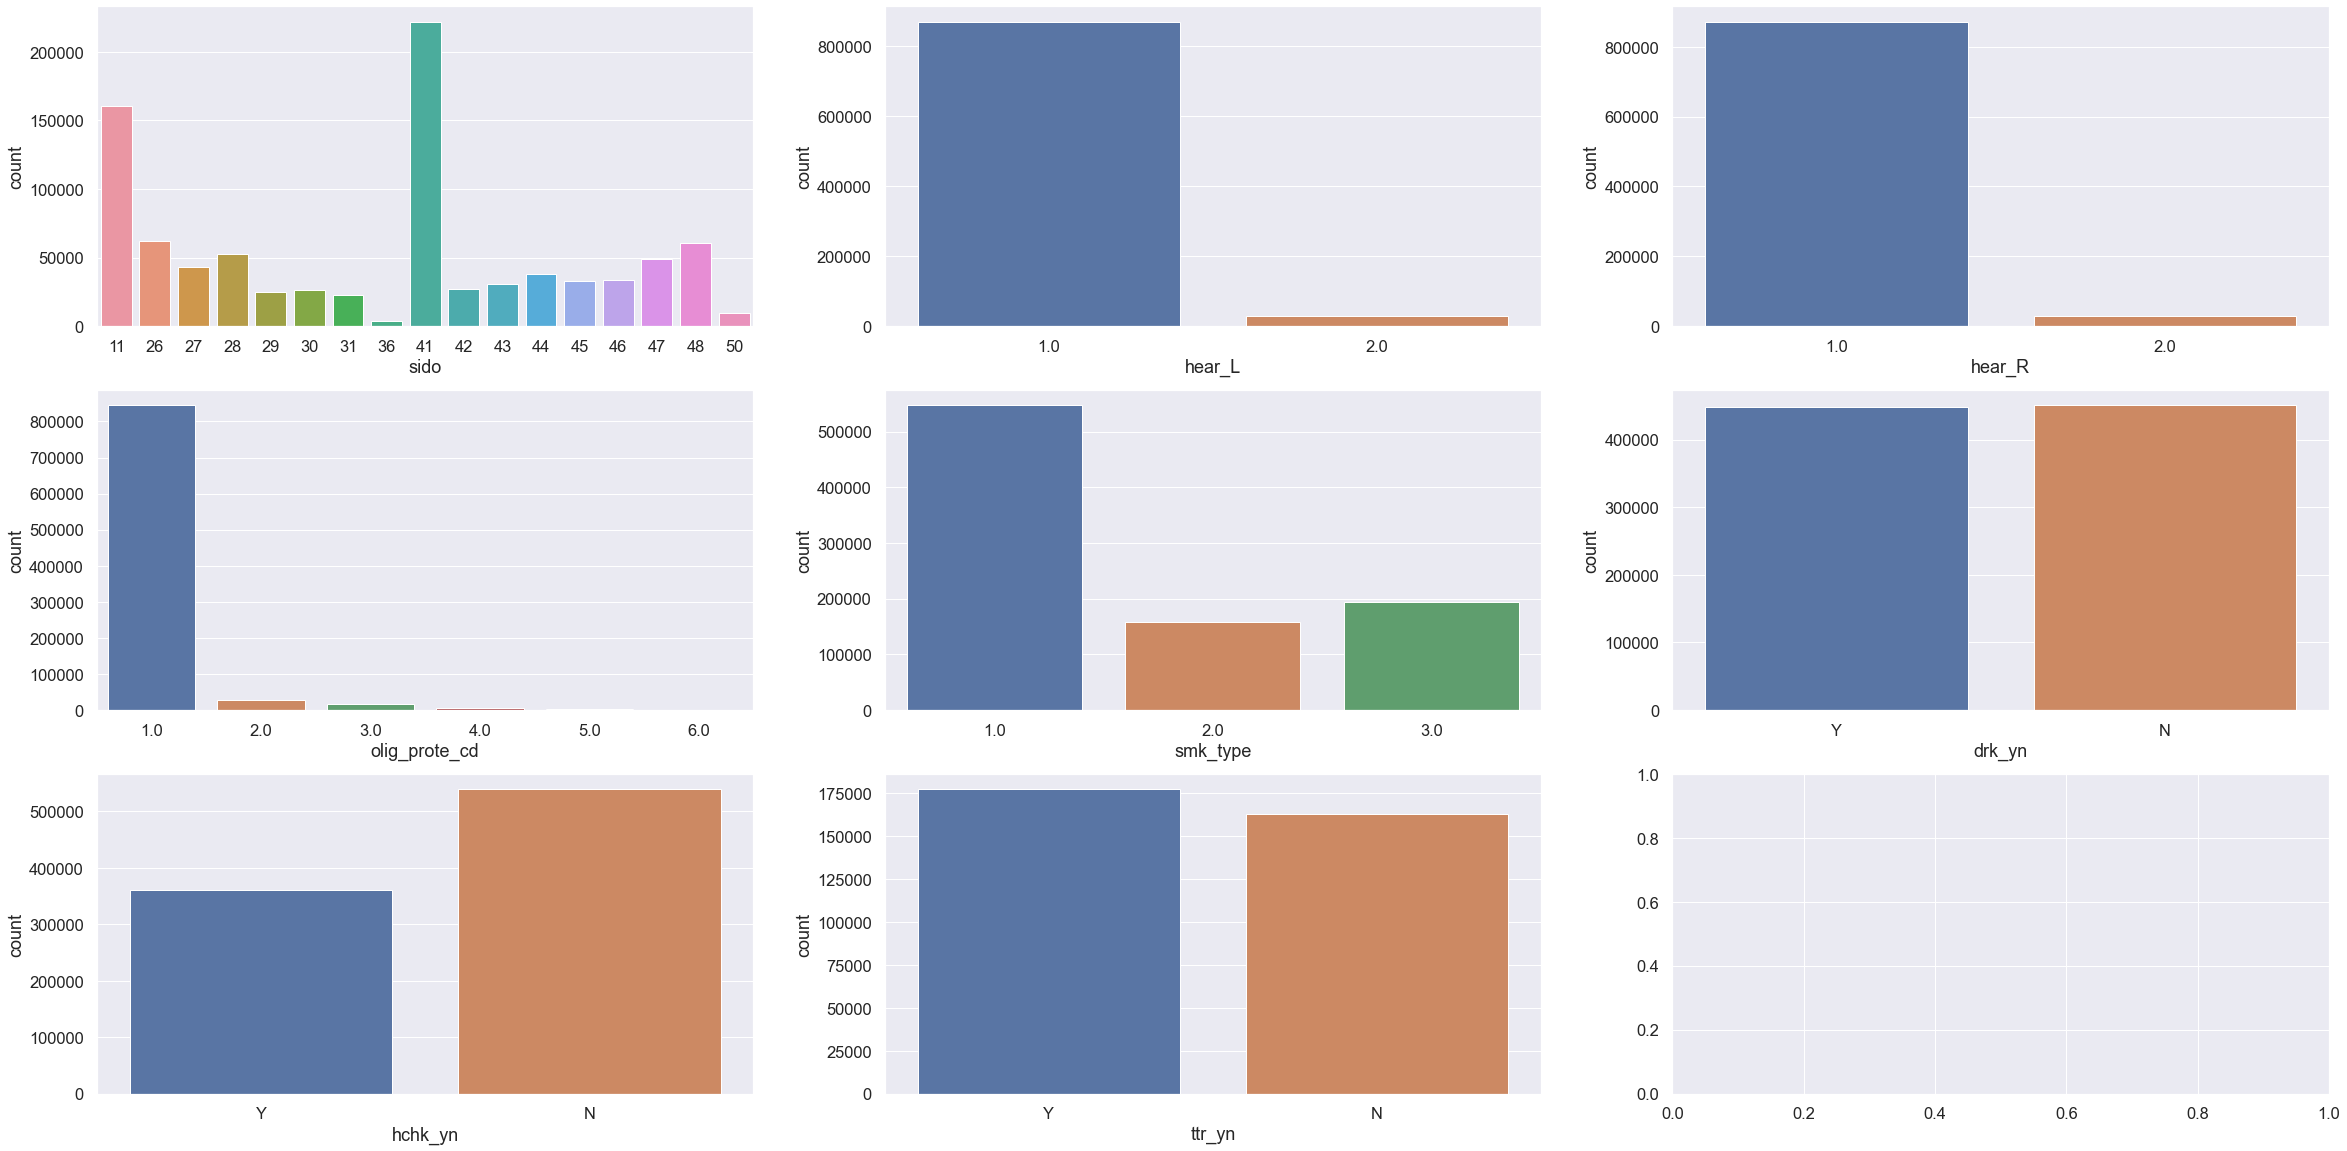

In [169]:
# count plot 한 번 그려보자고

figure, ((ax1,ax2,ax3),(ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(nrows = 3, ncols = 3) 
figure.set_size_inches(40,20)

sns.countplot(data=df_train, x = 'sido', ax = ax1)
sns.countplot(data=df_train, x = 'hear_L', ax = ax2) 
sns.countplot(data=df_train, x = 'hear_R',ax = ax3) 
sns.countplot(data=df_train, x = 'olig_prote_cd',ax = ax4) 
sns.countplot(data=df_train, x = 'smk_type',ax = ax5) 
sns.countplot(data=df_train, x = 'drk_yn',ax = ax6) 
sns.countplot(data=df_train, x = 'hchk_yn',ax = ax7) 
sns.countplot(data=df_train, x = 'ttr_yn',ax = ax8) 

In [ ]:
# 지역별 분포도 원을 그려서 확인


<AxesSubplot:xlabel='sido', ylabel='count'>

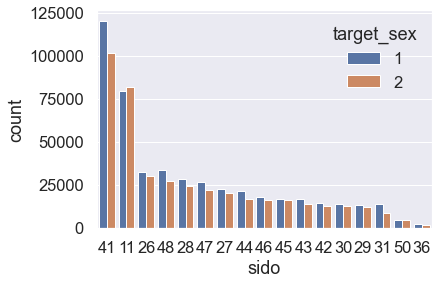

In [181]:
# 지역별 확인

# figure, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows = 3, ncols = 3) 
# figure.set_size_inches(50,15) 
sns.countplot(data=df_train, x = "sido", hue = "target_sex", order = df_train['sido'].value_counts().index)

<AxesSubplot:xlabel='target_age', ylabel='count'>

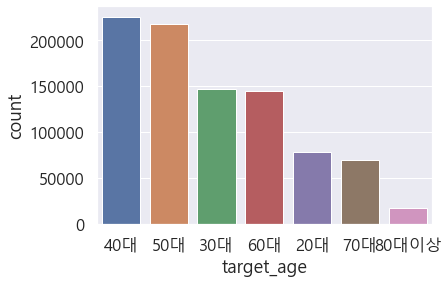

In [190]:
sns.countplot(data=df_train, x = "target_age", order = df_train['target_age'].value_counts().index)